# Comparing Representations

---

*Problem Space*

We now have several representations we can test, the most promising being:

- BoT (a Bag-of-upto-Trigrams with 2,000 terms)
- Tfidf (the Tfidf of the BoT)
- SVD (a 300-component svd of either the BoT or the Tfidf)
- New features (minus RSR)
- Document length (raw)

The number of ways in which these can be combined results in a large problem space. Using intuition alone I've decided to narrow down the comparisons to the following representations:

    1. BoT: accuracy
    2. SVD on Tfidf
    3. BoT + new features
    4. BoT + document length
    5. SVD on Tfidf + new features
    6. SVD on Tfidf + document length

*Results*

Given the baseline logistic classifier:

- Overall accuracy and specificity are high
- Sensitivity, which is desired, is the metric that needs improvement
- The original BoT has the best sensitivity
- This BoT plus all features minus RSR has the second-best sensitivity, then plus document length
- SVD alone has bad sensitivity, this is improved with all features but RSR

*Keep*

- BoT alone
- BoT with all features but RSR
- SVD with all features but RSR (to test out with a more complex model)


## Setup

In [1]:
import os
import time

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-27


## Load Data

In [2]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("..","data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

In [3]:
%%capture output

# custom feature engineering module
import custom.feature_engineering as Fe

try:                   
    clean_train_docs, X_train_feat = Fe.DocumentToFeaturesCounterTransformer().fit_transform(X_train)
except Warning as e:
    pass

# impute with zeros
X_train_feat[np.isnan(X_train_feat)] = 0

## Create Representations


### 1. BoT

A Bag-of-upto-Trigrams with a vocabulary size of 2,000 terms.

In [4]:
import custom.clean_preprocess as cp
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))                  
                ])

X_counter = pipe['counter'].fit_transform(X_train)
X_bot = pipe['bot'].fit_transform(X_counter)

### 2. SVD on Tfidf

The same Bag-of-upto-Trigrams of 2,000 terms that is TF-IDFed, and SVD is performed to reduce it to 300 components.

In [5]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
from sklearn.preprocessing import MinMaxScaler

def perform_SVD(X, k=300):
    U, Sigma, VT = svds(X.T, # transposed to a term-document matrix
                    k=k) # k = number of components
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    # scale
    V = VT.T
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(V)
    return X_scaled

# tfidf
X_tfidf = pipe.fit_transform(X_train)

# svd
X_svd_tfidf = perform_SVD(X_tfidf)

### 3. BoT + All features but RSR

In [6]:
import scipy.sparse as sp

X_bot_feat = sp.hstack((X_bot, X_train_feat[:,0:6]))
X_bot_feat

<3900x2007 sparse matrix of type '<class 'numpy.float64'>'
	with 82468 stored elements in COOrdinate format>

### 4. BoT + raw document length

In [7]:
X_bot_doclen = sp.hstack((X_bot, X_train_feat[:,0:1]))
X_bot_doclen

<3900x2002 sparse matrix of type '<class 'numpy.float64'>'
	with 63002 stored elements in COOrdinate format>

### 5. SVD + All features but RSR

In [8]:
from scipy.sparse import csr_matrix

X_svd_feat = sp.hstack((csr_matrix(X_svd_tfidf), X_train_feat[:, 0:6]))
X_svd_feat

<3900x306 sparse matrix of type '<class 'numpy.float64'>'
	with 1192930 stored elements in COOrdinate format>

### 6. SVD + raw document length

In [9]:
X_svd_doclen = sp.hstack((csr_matrix(X_svd_tfidf), X_train_feat[:,0:1]))
X_svd_doclen

<3900x301 sparse matrix of type '<class 'numpy.float64'>'
	with 1173464 stored elements in COOrdinate format>

## Quick Modeling

In [10]:
# transform y_array into int type
y_train[y_train=='ham'] = 0
y_train[y_train=='spam'] = 1
y_train = y_train.astype('int')

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)

scorer_ = {
    'acc': make_scorer(accuracy_score),
    'tpr': make_scorer(recall_score, pos_label=1),
    'tnr': make_scorer(recall_score, pos_label=0)
}

In [12]:
# list of representations
Xs = [
      X_bot, 
      X_svd_tfidf, 
      X_bot_feat, 
      X_bot_doclen,
      X_svd_feat,
      X_svd_doclen
     ]

# list of  names
Xnames = [
          'X_bot',
          'X_svd_tfidf', 
          'X_bot_feat', 
          'X_bot_doclen', 
          'X_svd_feat', 
          'X_svd_doclen', 
         ]

In [13]:
accs, tprs, tnrs = [], [], []
for X_ in Xs:
    acc = cross_val_score(log_clf, X_, y_train, cv=10, verbose=0, scoring=scorer_['acc'], n_jobs=-1)
    tpr = cross_val_score(log_clf, X_, y_train, cv=10, verbose=0, scoring=scorer_['tpr'], n_jobs=-1)
    tnr = cross_val_score(log_clf, X_, y_train, cv=10, verbose=0, scoring=scorer_['tnr'], n_jobs=-1)
    accs.append(round(acc.mean(),4))
    tprs.append(round(tpr.mean(),4))
    tnrs.append(round(tnr.mean(),4))

data = {'representation':Xnames,
        'accuracy':accs,
        'sensitivity':tprs,
        'specificity':tnrs}

df = pd.DataFrame(data)
df

,representation,accuracy,sensitivity,specificity
0,X_bot,0.9859,0.9069,0.9979
1,X_svd_tfidf,0.9836,0.8857,0.9985
2,X_bot_feat,0.9849,0.9031,0.9973
3,X_bot_doclen,0.9846,0.9011,0.9973
4,X_svd_feat,0.9828,0.8973,0.9959
5,X_svd_doclen,0.9823,0.8896,0.9965


In [14]:
# get vectors for plotting
mean_accs  = [x for x in df.loc[:,"accuracy"]]
mean_sens = [x for x in df.loc[:,"sensitivity"]]
mean_spec  =  [x for x in df.loc[:,"specificity"]]

### Evaluate Representations

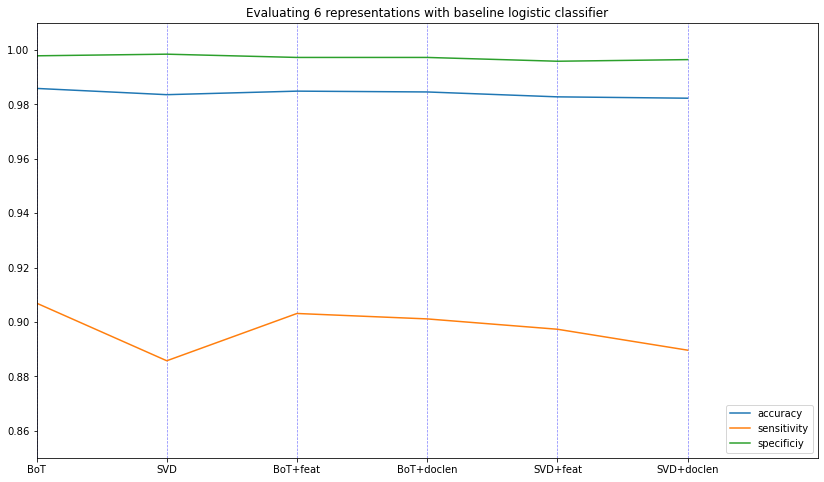

In [15]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(14, 8)) 
plt.plot(mean_accs, label="accuracy")
plt.plot(mean_sens, label="sensitivity")
plt.plot(mean_spec, label="specificiy")
plt.title('Evaluating 6 representations with baseline logistic classifier')
plt.xticks(np.arange(6), ('BoT', 
                          'SVD', 
                          'BoT+feat', 
                          'BoT+doclen',
                          'SVD+feat',
                          'SVD+doclen'))
plt.vlines(np.arange(6), ymin=.85, ymax=1.01, linestyle='dashed', colors='b', alpha=.5, linewidth=.7)
plt.legend(loc="lower right")
plt.axis([0, 6, 0.85, 1.01])
plt.show()

*Results*

- Overall accuracy and specificity are high
- Sensitivity, which is desired, is the metric that needs improvement
- The original BoT has the best sensitivity (0.9069)
- This BoT plus new features has the second-best sensitivity (0.9031)
- This BoT plus document length has the third-best sensitivty (0.9011)
- SVD alone has bad sensitivity; it is improved with new features (0.8973)

*Keep*

- BoT alone
- BoT with new features except RSR
- SVD with new features except RSR, to test with a more complex model


### Precision-Recall Curves


The PR curves below are less robust since I'm not performing cross validation.

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split

def plot_PR(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    log_clf = LogisticRegression(solver="liblinear", random_state=42)
    log_clf.fit(X_train, y_train)
    p = plot_precision_recall_curve(log_clf, X_test, y_test)

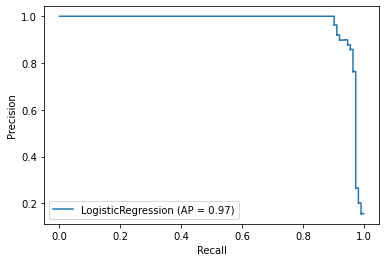

In [17]:
plot_PR(X_bot, y_train)

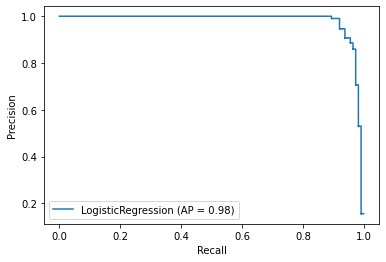

In [18]:
plot_PR(X_svd_tfidf, y_train)

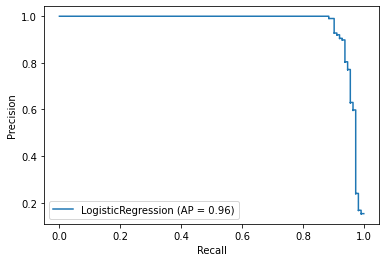

In [19]:
plot_PR(X_bot_feat, y_train)

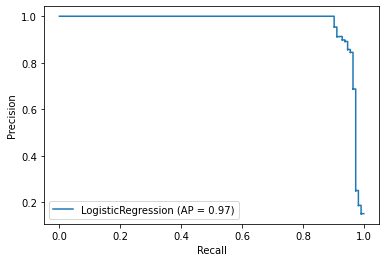

In [20]:
plot_PR(X_bot_doclen, y_train)

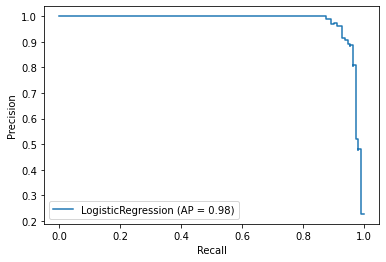

In [21]:
plot_PR(X_svd_feat, y_train)

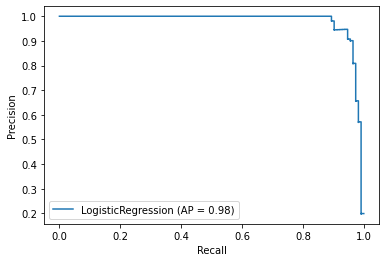

In [22]:
plot_PR(X_svd_doclen, y_train)

In [23]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 0 m 50 s


---